# AnyoneAI - Project II

# Making Estimations with our NBA dataset

In our first project, we learn how to create our own datasets by using a public API, Python and Pandas. We're now going to explore how to make predictive models for regression and classification tasks using ScikitLearn

The goals of this project are:
- Learn how to define a prediction task
- Selecting evaluation metrics and baseline models
- Perform feature engineering and standarization
- Training and using predictive models: Univariable and Multivariate Linear Regression, Classification
- Understand how Gradient Descent works by implementing a Linear Regressor in python

## Using Regression Models to Estimate players Salaries

A player's salary can be explained by a lot of factors: 

- Years in the league: NBA contracts are limited in price, players have caps on how much money they make depending on their years playing in the league
- Age: Highly correlated to the previous one, NBA players have a minimun age of 19 years
- Draft position: players out of USA universities are selected each year through a process called draft, in which each team selects a player in a predefined order for 2 rounds (meaning only 60 players are drafted each year). A rookie contract value depends on the draft position. (Undrafted players have to negotiate a salary independently)
- Performance in statistical categories: after the rookie contract, players can negotiate freely with teams, and usually statistical categories like points, rebounds and assists are extremely important.  
- Team: Even though there are limits to what all teams can expend in players salary, they all allocate their resources differently, and can be more willing to pay the penalties incurred by exceeding those limitations.
- Year in which the contract was signed: the mininum and maximum values of contracts possibles in the NBA changes depending on league revenue (television contracts, sponsorships, etc), so if the amount of money the teams make increases, players can negotiate bigger contracts.
- Intangibles: players can be valued also in things that are not easily translated to a statistic, good defensive players might not always have great stats but can be extremely important for a team, the same can be said about veteran players that help young ones to learn and are good locker-room guys.

But we're going to take a simplified approach, we'll try to use the data we already have to make the best estimator possible, and then we will analyze what went right and what could've gone wrong with our results.

### Analyzing our data

In [362]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix

In [363]:
datasp2 = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/project2_players_df.csv")
datasp2.dropna(subset=["PTS"], inplace=True)
datasp2.dropna(subset=["TEAM_NAME"], inplace=True)

Let's have another look at our previously generated dataset. 

1.1. Plot all players statistics ("PTS", "REB", "AST","STL","BLK") against salary

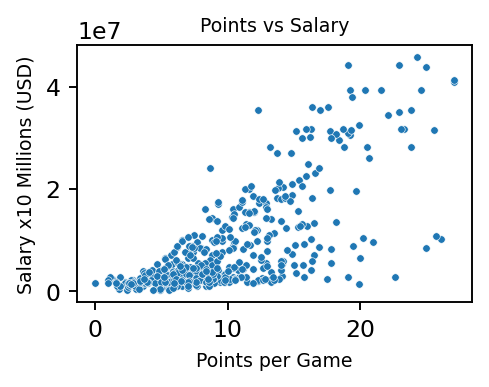

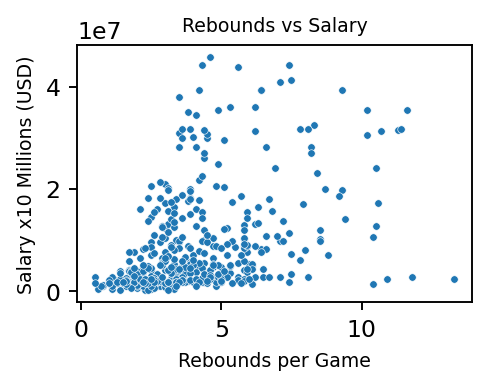

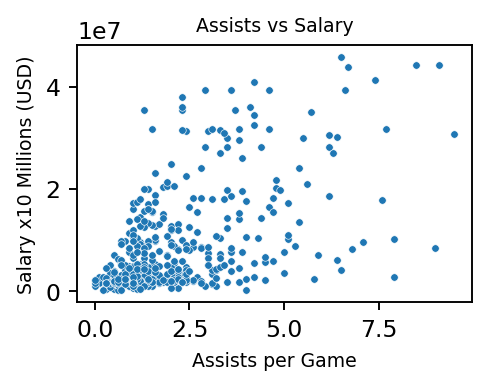

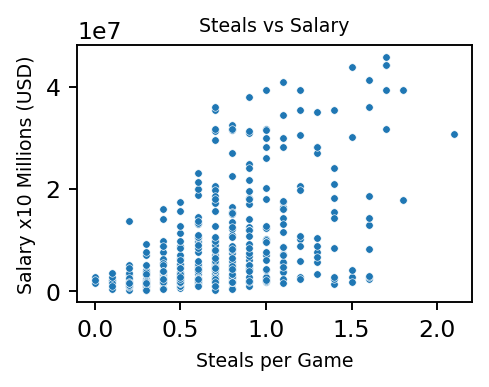

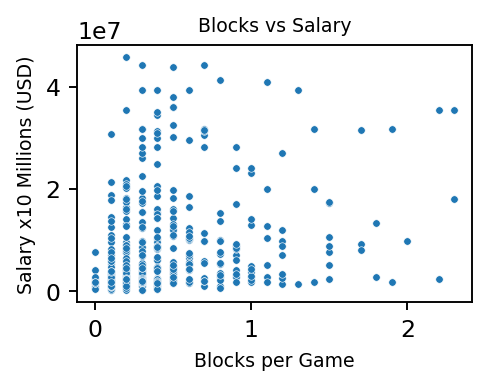

In [364]:
# I am creating different scatterplots to see the distribution of Salary vs all the other features...

fig, ax = plt.subplots(figsize =(3,2),dpi=170) 
sns.scatterplot(data = datasp2, x = 'PTS', y = 'Salary', s=10, palette='muted') 
ax.set_xlabel( "Points per Game" , size = 8 ) 
ax.set_ylabel( "Salary x10 Millions (USD)" , size = 8 ) 
ax.set_title( "Points vs Salary" , size = 8 ) 
plt.show()

fig, ax = plt.subplots(figsize =(3,2),dpi=170) 
sns.scatterplot(data = datasp2, x = 'REB', y = 'Salary', s=10, palette='muted') 
ax.set_xlabel( "Rebounds per Game" , size = 8 ) 
ax.set_ylabel( "Salary x10 Millions (USD)" , size = 8 ) 
ax.set_title( "Rebounds vs Salary" , size = 8 ) 
plt.show()

fig, ax = plt.subplots(figsize =(3,2),dpi=170) 
sns.scatterplot(data = datasp2, x = 'AST', y = 'Salary', s=10, palette='muted') 
ax.set_xlabel( "Assists per Game" , size = 8 ) 
ax.set_ylabel( "Salary x10 Millions (USD)" , size = 8 ) 
ax.set_title( "Assists vs Salary" , size = 8 ) 
plt.show()

fig, ax = plt.subplots(figsize =(3,2),dpi=170) 
sns.scatterplot(data = datasp2, x = 'STL', y = 'Salary', s=10, palette='muted') 
ax.set_xlabel( "Steals per Game" , size = 8 ) 
ax.set_ylabel( "Salary x10 Millions (USD)" , size = 8 ) 
ax.set_title( "Steals vs Salary" , size = 8 ) 
plt.show()

fig, ax = plt.subplots(figsize =(3,2),dpi=170) 
sns.scatterplot(data = datasp2, x = 'BLK', y = 'Salary', s=10, palette='muted') 
ax.set_xlabel( "Blocks per Game" , size = 8 ) 
ax.set_ylabel( "Salary x10 Millions (USD)" , size = 8 ) 
ax.set_title( "Blocks vs Salary" , size = 8 ) 
plt.show()

1.2. What can we say about these distributions?

In [365]:
# Among these parameters, POINTS feature is the one who has the strongest relationship with the Salary.  
# This means the more points a player scores, the more salary he earns.

### Splitting the Dataset

1.3. Split the dataset into train and testing sets. Use the Sklearn function for train/test splitting. Make sure to set the random state for reproducibility.

In [403]:
from sklearn.model_selection import train_test_split

np.random.seed(42)

train_points, test_points, train_salaries, test_salaries = train_test_split(datasp2, datasp2['Salary'], test_size=0.30, random_state=42)

print(train_points.shape)
print(test_points.shape)
print(train_salaries.shape)
print(test_salaries.shape)

(305, 20)
(132, 20)
(305,)
(132,)


### Baseline Model and Evaluation Metric

In every project, we need a baseline model that implements a very simple algorithm or heuristic so we can compare our results with it. 
In this case, we could create a function that always returns the average player salary, evaluate that, and then compare the result with our modeling to see if we are improving. 

We need an evaluation metric to see how well our models fit the data. For this project we will use [Mean Absolute Error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html#sklearn.metrics.mean_absolute_error) as our regression evaluation metric, because it is a really simple metric to interpret. A lower value means the model performs better. 

For this particular problem, we will always round the value, as we don't need decimals for this task.

1.4. Create a Baseline model class that implements  fit() and predict() methods. As this model will not consider any other variable, the fit method should only receive a list of all players salaries. The predict method should receive and iterable and return a numpy array with the same length but every element should have the same value (the average salary)

In [398]:
class BaselineModel():

    """A baseline model that always returns the same value, the mean of the players salary in the train data"""
      
        
    def fit(self, train_salaries):
        """
        Fit the training data. 
        
        Parameters
        ----------
        train_salaries: Union[pd.Series, np.ndarray]
            a pandas series or numpy array containing salary information
        

        """

        self.mean = int(np.mean(train_salaries))
        print(self.mean)
    
    def predict(self, points):
      
        """
        Predict salaries 
        
        Parameters
        ----------
        points: Union[pd.DataFrame, pd.Series, np.ndarray]
            a pandas series, dataframe or numpy array with the             
            Returns
        -------
        np.ndarray
            a numpy array of the same length as points, with all elements equal to the mean salary calculated in fit()
        """
        predictions = np.array([self.mean] * len(d_test.index))
        return predictions

1.5. Evaluate the performance of our BaselineModel on the test set using mean_absolute_error from Sklearn (round the result)

In [399]:
model = BaselineModel()
model.fit(train_salaries)
predictions = model.predict(test_points)

mae_baseline = np.round(mean_absolute_error(test_salaries, predictions))

print(f"Mean Absolute Error of model: {mae_baseline}")

9065038
Mean Absolute Error of model: 7361070.0


### Regression with a single variable

You're now going to start modeling data. We will start with a really simple approach, selecting just one variable, and doing a regression to see if we improve upon our baseline.


1.6. Select the variable you think would provide the best fit. Perform feature scaling on this variable using a Sklearn scaler.

In [405]:
#Using the SGDRegressor I tried 2 different Scalers, to check what is the lowest Mean
# On this block code I used the Standard Scaler...

std_scaler = StandardScaler()

train_points = std_scaler.fit_transform(train_points['PTS'].values.reshape(-1,1))
test_points = std_scaler.transform(test_points['PTS'].values.reshape(-1,1))

sgd_model = SGDRegressor(random_state=42)

sgd_model.fit(train_points, train_salaries)

pred = sgd_model.predict(test_points)
print(f"Mean Absolute Error of SGDRegressor model: {np.round(mean_absolute_error(test_salaries, pred))}")

Mean Absolute Error of SGDRegressor model: 5021973.0


In [404]:
# and here I used the MinMax Scaler...

mmx_scaler = MinMaxScaler()

train_points2 = mmx_scaler.fit_transform(train_points['PTS'].values.reshape(-1,1))
test_points2 = mmx_scaler.transform(test_points['PTS'].values.reshape(-1,1))

sgd_model2 = SGDRegressor(random_state=42)

sgd_model2.fit(train_points2, train_salaries)

pred2 = sgd_model2.predict(test_points2)
print(f"Mean Absolute Error of SGDRegressor model: {np.round(mean_absolute_error(test_salaries, pred2))}")

Mean Absolute Error of SGDRegressor model: 4991033.0


1.7. Train a model with [SGDRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html) from Sklearn using the default parameters. Evaluate the model's performance on the test set using the selected metric.

In [406]:
# As I trained the model on the previous block, here I am just re-printing the Mean Absolute Error...

print(f"Mean Absolute Error of SGDRegressor model: {np.round(mean_absolute_error(test_salaries, pred2))}")
print()

Mean Absolute Error of SGDRegressor model: 4991033.0



1.8. Read the Sklearn documentation, and write a function that tries different configurations for the hyperparameters for training: epochs, learning rate and alpha. For each combination of parameters, evaluate the trained algorithm on the test set, then save the results of each hyperparameter combination, finally select the one that has the best MAE (meaning the lowest number) and print the combination and the MAE.

In [416]:
def search_best_hyperparameters(epochs, learning_rates):
    
    '''
    The purpose of this Function is to:
    1) Iterate the algorithm considering different configuration of hyperparameters.
    2) Use a For loop to start the iteration considering None value for the hyperparameters.
    3) Run the SGDRegressor assigning the saved values of hyperparameters.
    4) Fit the trained data and build the predictor, saving in a local variable.
    5) Calculate the Mean Absolute Error - MAE.
    6) Use If and Else to bring the lowest value of MAE. 
        
    '''
    
    result = {"hyperparameters": {"epochs": None, "lr": None}, 
        "mae": None}

    for ep in epochs:
        for lr in learning_rates:
            print(ep, '-',lr)
            SGDR = SGDRegressor(max_iter=ep, eta0=lr, random_state=42)
            SGDR.fit(train_points, train_salaries)
            salary_pred = SGDR.predict(test_points)
            mean_to_mae = (round(mean_absolute_error(salary_pred, test_salaries)))
            print(mean_to_mae)
        if result["mae"] == None:
          result["hyperparameters"]["epochs"] = ep
          result["hyperparameters"]["lr"] = lr
          result["mae"] = mean_to_mae
        else:
            if result["mae"] > mean_to_mae:
                result["hyperparameters"]["epochs"] = ep
                result["hyperparameters"]["lr"] = lr
                result["mae"] = mean_to_mae

    return result

In [419]:
# This is the application of the Function to get the lowest MAE using different configuration of hyperparameters...

epochs = [1000, 1000000]
learning_rates = [0.0001, 0.001, 0.01, 0.1]

final_result = search_best_hyperparameters(epochs, learning_rates)
print(f'The lowest value for the MAE is: {final_result}')

1000 - 0.0001
4946088
1000 - 0.001
5013383
1000 - 0.01
5021973
1000 - 0.1
5003567
1000000 - 0.0001


C:\Users\abela\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


5013510
1000000 - 0.001
5013383
1000000 - 0.01
5021973
1000000 - 0.1
5003567
The lowest value for the MAE is: {'hyperparameters': {'epochs': 1000, 'lr': 0.1}, 'mae': 5003567}


1.9. Compare the results of the baseline, the SGDRegressor with default parameters and the one with the best combination of hyperparameters you could find. (replace variables with the ones you used)

In [420]:
print("Mean Absolute Error for each model:")
print(f"Baseline: {mae_baseline}")
print(f"Default SGDRegressor: {mae_sgd}")
print(f"Best SGDRegressor: {final_result}")

Mean Absolute Error for each model:
Baseline: 7361070.0
Default SGDRegressor: 4991033.0
Best SGDRegressor: {'hyperparameters': {'epochs': 1000, 'lr': 0.1}, 'mae': 5003567}


### Multivariate Linear Regression

To improve our model, we will add more features to it. We will have to do some processing to our dataset to be able to use the data.
We'll start with the following variables:

- Points
- Rebounds
- Assists
- Blocks
- Experience
- Position
- Draft Number


1.10. Create a copy of the dataset generated in the first project that only has the following columns (and player id as an index):

["PTS", "REB", "AST", "BLK", "SEASON_EXP", "POSITION", "DRAFT_NUMBER", "TEAM_NAME", "SALARY"]

In [421]:
datasp3 = datasp2.filter(["PERSON_ID", "PTS", "REB", "AST", "BLK", "SEASON_EXP", "POSITION", "DRAFT_NUMBER","TEAM_NAME", "Salary"], axis=1)
datasp3.set_index('PERSON_ID', inplace=True)
datasp3.head()

,PTS,REB,AST,BLK,SEASON_EXP,POSITION,DRAFT_NUMBER,TEAM_NAME,Salary
PERSON_ID,,,,,,,,,
1630173,6.5,5.1,0.8,0.5,1,Forward,20,Raptors,2711280
203500,9.3,7.9,1.4,0.9,8,Center,12,Grizzlies,17073171
1628389,13.2,8.2,3.5,0.9,4,Center,14,Heat,28103550
1630583,3.3,2.4,0.5,0.3,0,Forward,30,Grizzlies,1994520
200746,19.1,8.1,1.9,1.1,15,Center,2,Nets,2641691


#### Feature Engineering

1.11. Binning the DRAFT_NUMBER feature. Draft position directly impacts salaries during the first few years, but second round players and undrafted players don't have guaranteed contracts. So we're gonna divide the bins like this: 

       - 1 to 15: firstround_lottery
       - 15 to 30: firstround_non_lottery
       - 30 to 60: second_round
       - Undrafted: undrafted
       
Create a new column named DRAFT using these 4 categories. Drop the draft number column.

In [422]:
# In order to create and apply these labels I used Bins and set specific range of values for each one
# For the first Bin Undrafted I filled the Null Values with the proper label in the range of 0-1

datasp3['DRAFT_NUMBER'] = datasp3['DRAFT_NUMBER'].fillna(0)
datasp3['DRAFT_NUMBER'] = datasp3['DRAFT_NUMBER'].replace('Undrafted', 0)
datasp3['DRAFT_NUMBER'] = datasp3['DRAFT_NUMBER'].astype(int)
draft_labels = ['undrafted', 'firstround_lottery', 'firstround_non_lottery', 'second_round']
datasp3['DRAFT']= pd.cut(datasp3['DRAFT_NUMBER'], bins=[0,1,15,30,60], labels=draft_labels)
datasp3['DRAFT'] = datasp3['DRAFT'].fillna('undrafted')
datasp3.drop('DRAFT_NUMBER', axis=1, inplace=True)
datasp3.head()

,PTS,REB,AST,BLK,SEASON_EXP,POSITION,TEAM_NAME,Salary,DRAFT
PERSON_ID,,,,,,,,,
1630173,6.5,5.1,0.8,0.5,1,Forward,Raptors,2711280,firstround_non_lottery
203500,9.3,7.9,1.4,0.9,8,Center,Grizzlies,17073171,firstround_lottery
1628389,13.2,8.2,3.5,0.9,4,Center,Heat,28103550,firstround_lottery
1630583,3.3,2.4,0.5,0.3,0,Forward,Grizzlies,1994520,firstround_non_lottery
200746,19.1,8.1,1.9,1.1,15,Center,Nets,2641691,firstround_lottery


1.12. Encode the categorical features: DRAFT, POSITION and TEAM_NAME

In [423]:
datasp3 = pd.get_dummies(datasp3, columns=["DRAFT","POSITION","TEAM_NAME"], prefix=["Draft:", "Position:", "Team:"] )
datasp3.head()

,PTS,REB,AST,BLK,SEASON_EXP,Salary,Draft:_undrafted,Draft:_firstround_lottery,Draft:_firstround_non_lottery,Draft:_second_round,...,Team:_Pistons,Team:_Raptors,Team:_Rockets,Team:_Spurs,Team:_Suns,Team:_Thunder,Team:_Timberwolves,Team:_Trail Blazers,Team:_Warriors,Team:_Wizards
PERSON_ID,,,,,,,,,,,,,,,,,,,,,
1630173,6.5,5.1,0.8,0.5,1,2711280,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
203500,9.3,7.9,1.4,0.9,8,17073171,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1628389,13.2,8.2,3.5,0.9,4,28103550,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1630583,3.3,2.4,0.5,0.3,0,1994520,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
200746,19.1,8.1,1.9,1.1,15,2641691,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Modeling

1.13. Split the dataset into train and test

In [424]:
mv_x_train, mv_x_test, mv_y_train, mv_y_test = train_test_split(datasp3, datasp3['Salary'], test_size=0.30, random_state=42)

mv_x_train.drop(['Salary'], axis=1, inplace=True)
mv_x_test.drop(['Salary'], axis=1, inplace=True)
mv_x_train.head()

C:\Users\abela\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,PTS,REB,AST,BLK,SEASON_EXP,Draft:_undrafted,Draft:_firstround_lottery,Draft:_firstround_non_lottery,Draft:_second_round,Position:_Center,...,Team:_Pistons,Team:_Raptors,Team:_Rockets,Team:_Spurs,Team:_Suns,Team:_Thunder,Team:_Timberwolves,Team:_Trail Blazers,Team:_Warriors,Team:_Wizards
PERSON_ID,,,,,,,,,,,,,,,,,,,,,
201961,8.0,2.1,1.1,0.1,12,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1630537,13.3,4.1,2.2,0.2,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
203932,12.9,6.3,2.5,0.6,7,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1630553,3.4,1.6,0.9,0.2,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1627751,7.1,5.9,1.4,1.2,5,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0


1.14. Perform feature scaling in all the numerical features ("PTS", "REB", "AST", "BLK", "SEASON_EXP") except for draft number

In [425]:
mmx_scaler2 = MinMaxScaler()

cols_to_scale = ["PTS", "REB", "AST", "BLK", "SEASON_EXP"]

# train dataset scaling 
mv_x_train[cols_to_scale] = mmx_scaler2.fit_transform(mv_x_train[cols_to_scale])

# test dataset scaling
mv_x_test[cols_to_scale] = mmx_scaler2.transform(mv_x_test[cols_to_scale])

<ipython-input-425-dac8b30c6779>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mv_x_train[cols_to_scale] = mmx_scaler2.fit_transform(mv_x_train[cols_to_scale])
C:\Users\abela\anaconda3\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
<ipython-input-425-dac8b30c6779>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1.15. Write a function to train a SGDRegressor model with the new dataset, trying different hyperparameters, and selecting the one that performs the best.

In [426]:
def search_best_hyperparameters_sgdr(epochs, learning_rates):
    
    '''
    The purpose of this Function is to:
    1) Iterate the algorithm considering different configuration of hyperparameters.
    2) Use a For loop to start the iteration considering None value for the hyperparameters.
    3) Run the SGDRegressor assigning the saved values of hyperparameters.
    4) Fit the trained data and build the predictor, saving in a local variable.
    5) Calculate the Mean Absolute Error - MAE.
    6) Use If and Else to bring the lowest value of MAE. 
        
    '''
    
    result = {
        "hyperparameters": {"epochs": None, "lr": None}, 
        "mae": None}

    for ep in epochs:
        for lr in learning_rates:
            print(ep, '-',lr)
            SGDR = SGDRegressor(max_iter=ep, eta0=lr, random_state=42)
            SGDR.fit(mv_x_train, mv_y_train)
            salary_pred = SGDR.predict(mv_x_test)
            mean_to_mae = (round(mean_absolute_error(salary_pred, mv_y_test)))
            print(mean_to_mae)
        if result["mae"] == None:
            result["hyperparameters"]["epochs"] = ep
            result["hyperparameters"]["lr"] = lr
            result["mae"] = mean_to_mae
        else:
            if result["mae"] > mean_to_mae:
                result["hyperparameters"]["epochs"] = ep
                result["hyperparameters"]["lr"] = lr
                result["mae"] = mean_to_mae

    return result

In [427]:
# This below is the list of the different configuration of the hyperparameters...

epochs = [1000, 1000000]
learning_rates = [0.0001, 0.001, 0.01, 0.1]

low_mae_sgdr = search_best_hyperparameters_sgdr(epochs, learning_rates)

print(f'The lowest MAE using is all numerical features is: {low_mae_sgdr}')

1000 - 0.0001
6516141
1000 - 0.001


C:\Users\abela\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\abela\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


5288412
1000 - 0.01
5295914
1000 - 0.1
5348098
1000000 - 0.0001


C:\Users\abela\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


5449041
1000000 - 0.001
5451282
1000000 - 0.01
5295914
1000000 - 0.1
5348098
The lowest MAE using is all numerical features is: {'hyperparameters': {'epochs': 1000, 'lr': 0.1}, 'mae': 5348098}


1.16. How did the model performed compared to our univariate models? 

This model performed better using all the numerical features vs. using previous univariate.
I used the same values on hyperparameters to compare them in an identical way.
My best final result now is $ 4.7 mdd vs $ 4.9 mdd obtained previously.

### DecisionTreeRegressor

It is possible that this problem might not be easily resolvable by a linear model, or that there could be better types of algorithms to tackle it. As an example, let's try with a very used algorithm, a Decision Tree.



1.17. Create new model using [DecisionTreeRegressor](https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html) from scikit learn. We will use again all variables, and try different configuration for the following hyperparameters:

- max_depth
- min_samples_leaf
- max_features

These are all regularization hyperparameters for this algorithm. Read the documentation to get a better grasp of what each one does.

In [428]:
from sklearn.tree import DecisionTreeRegressor

def search_best_hyperparameters_dtree(max_depth, min_samples_leaf, max_features):
    
    '''
    The purpose of this Function is to:
    1) Iterate the algorithm considering different configuration of hyperparameters.
    2) Use a For loop to start the iteration considering None value for the hyperparameters.
    3) Run the Decision Tree Regressor assigning the saved values of hyperparameters.
    4) Fit the trained data and build the predictor, saving in a local variable.
    5) Calculate the Mean Absolute Error - MAE.
    6) Use If and Else to bring the lowest value of MAE. 
        
    '''
        
    result = {"hyperparameters": {"max_depth": None, "min_samples_leaf": None, "max_features": None}, 
        "best mae on decision tree": None}

    for mxd in max_depth:
        for mns in min_samples_leaf:
            for mxf in max_features:
#                 print(f'{mxd}-{mns}-{mxf}')
                DTREE = DecisionTreeRegressor(max_depth=mxd, min_samples_leaf=mns, max_features=mxf, random_state=42)
                DTREE.fit(mv_x_train, mv_y_train)
                salary_pred_dtree = DTREE.predict(mv_x_test)
                mae_dtree = (round(mean_absolute_error(salary_pred_dtree, mv_y_test)))
#                 print(mae_dtree)
            if result["best mae on decision tree"] == None:
                result["hyperparameters"]["max_depth"] = mxd
                result["hyperparameters"]["min_samples_leaf"] = mns
                result["hyperparameters"]["max_features"] = mxf    
                result["best mae on decision tree"] = mae_dtree
            else:
                  if result["best mae on decision tree"] > mae_dtree:
                        result["hyperparameters"]["max_depth"] = mxd
                        result["hyperparameters"]["min_samples_leaf"] = mns
                        result["hyperparameters"]["max_features"] = mxf    
                        result["best mae on decision tree"] = mae_dtree

    return result

In [430]:
# This below is the list of the different configuration of the hyperparameters...

max_depth = [5, 10, 15, 20, 50]
min_samples_leaf = [2, 10, 20, 50]
max_features = [5,41]

low_mae_dtree = search_best_hyperparameters_dtree(max_depth, min_samples_leaf, max_features)

print(f'The lowest MAE with Decision Tree is: {low_mae_dtree}')

The lowest MAE with Decision Tree is: {'hyperparameters': {'max_depth': 10, 'min_samples_leaf': 10, 'max_features': 41}, 'best mae on decision tree': 3618169}


1.18. Compare the results obtained with the best decision tree model against the baseline, default and the best params sgd regressors-

In [431]:
print("Mean Absolute Error for each model:")
print(f"- Lowest MAE Univariate Baseline: {mae_baseline}")
print(f"- Lowest MAE Univariate Default: {mae_sgd}")
print(f"- Lowest MAE Univariate Best Params: {final_result}")
print(f'- Lowest MAE Multivariate SGD: {low_mae_sgdr}')
print(f'- Lowest MAE Multivariate Decision Tree: {low_mae_dtree}')

Mean Absolute Error for each model:
- Lowest MAE Univariate Baseline: 7361070.0
- Lowest MAE Univariate Default: 4991033.0
- Lowest MAE Univariate Best Params: {'hyperparameters': {'epochs': 1000, 'lr': 0.1}, 'mae': 5003567}
- Lowest MAE Multivariate SGD: {'hyperparameters': {'epochs': 1000, 'lr': 0.1}, 'mae': 5348098}
- Lowest MAE Multivariate Decision Tree: {'hyperparameters': {'max_depth': 10, 'min_samples_leaf': 10, 'max_features': 41}, 'best mae on decision tree': 3618169}


### Analyzing our results

Based on what you found, and what you read about players salaries above, answer the following: 

1.19. Which kind of model worked better in this dataset, linear or non linear models? Do you have any hypothesis about why? 

In [432]:
# For this dataset the nonlinear models worked better.  
# My hypothesis is that because we have more than one independent variable, non linear models produce smaller residuals.
# Residuals are the difference between an observed value of the response variable and the value of the response variable predicted from the regression line.

1.20. Is there something else we could do to improve our results if wanted to make a more accurate model?

<AxesSubplot:>

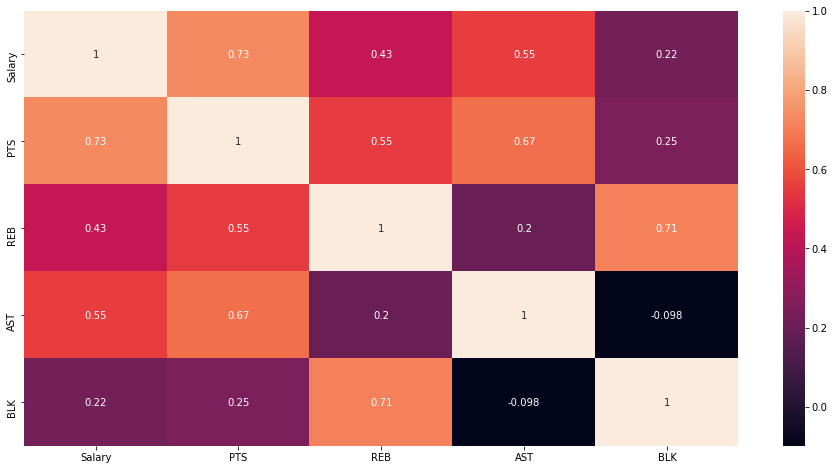

In [433]:
# We could create a heatmap to detect highly-correlated variables 
# For example in the heatmap below we can notice that besides Points&Salary, also Rebounds&Blocks are with high correlation.

num_with_salary = datasp2.filter(["Salary", "PTS", "REB", "AST", "BLK"], axis=1)
plt.figure(figsize=(16, 8))
sns.heatmap(num_with_salary.corr(), annot=True)

## Star or no Star? Predicting players All-NBA selections

In this section we're going to try to solve a different question:

Can we train a model to predict which players are going to be selected to ALL-NBA teams at the end of the season? This is a [binary classification](https://en.wikipedia.org/wiki/Binary_classification) task, so we're training our first classifier model to solve this problem.

Consider that:

- Being selected as part of the [All-NBA teams](https://en.wikipedia.org/wiki/All-NBA_Team) is different than being selected for [All-Star Game](https://en.wikipedia.org/wiki/NBA_All-Star_Game). 
- You're trying to predict All-NBA selections, which takes place after the regular season but before playoffs start, so we're only going to use players and teams statistics about the regular season (you're not going to consider if the players got to the NBA finals for example). 
- All Star game takes place at the middle point of the regular season, players are selected based on partial season performance, and the general public has 50% of the votes, so it is also a more popularity-based award.
- All-NBA teams are divided in first, second and third teams of 5 players each, divided by position: 2 front court players (guards), 2 backcourt players (forwards) and 1 center.
- As only 15 players are selected to All-NBA teams each year (out of more than 400 qualifying players), our dataset is going to be imbalanced. You're going to have to find a good strategy to deal with this inbalance.

### Analyzing the data

To do this task, you're going to need historical information about All-NBA selections. We'll use a dataset that contains information about players from season starting in 1990 and ending in the 2018-2019 season.
The dataset contains statistics for all players, and a column named "all-nba" that is going to be our target variable, 1 means the player was selected to an All-NBA team that season.


2.1. Load the dataset "all_nba_1990_2017_dataset.csv" from disk, look at the data inside it and print:
- number of rows
- number of seasons
- number of unique players
- number of all-nba selections vs non selected 

In [434]:
import pandas as pd
all_nba_df = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_1990_2017_dataset.csv", index_col=0)

# Here I created a mask that can be applied to the dataset to get only the seasons starting in 1990
mask_1 = (all_nba_df['season_start'] >= 1990)
all_nba_df = all_nba_df[mask_1]

print(f' -Number of rows is: {len(all_nba_df)}')
print(f" -Number of seasons is: {len(all_nba_df['season_start'].unique())}")
print(f" -Number of players is: {len(all_nba_df['player'].unique())}")

allnba_sel = all_nba_df.loc[all_nba_df['all_nba'] == 1]
allnba_sel = allnba_sel['player_id']
print(f" -Number of all-nba selections is: {len(allnba_sel.unique())}")

 -Number of rows is: 12419
 -Number of seasons is: 28
 -Number of players is: 2325
 -Number of all-nba selections is: 120


### Splitting the dataset

2.2. Split the dataset in training and test sets. Make sure to keep the distribution of values in the target variable.

Use columns: 'team', 'games', 'games_started', 'mp', 'fg_perc', '3p_perc',
       '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts','all_nba'
       
    

In [435]:
all_nba_df_filt = all_nba_df.filter(['team', 'games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc', 
                                '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts','all_nba'], axis=1)

cols_to_train = ['team', 'games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc', 
                                '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts']

X = all_nba_df_filt[cols_to_train]
y = all_nba_df_filt['all_nba']

allnba_x_train, allnba_x_test, allnba_y_train, allnba_y_test = train_test_split(X, 
                            y, test_size=0.30, random_state=42, stratify=y)

### Baseline model and Evaluation Metrics

In this oportunity we'll define our baseline model as the model we can train with the minimun amount of work on the dataset. For this you're gonna train a [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) with default parameters, and without doing any preprocessing to our data.

2.3. Let's start with a simple test. What accuracy would we get if we had a baseline model that always predicted 0 (player not selected to all nba)

In [436]:
# Pending to build the Baseline Model Here (below is only a reference)

class BaselineModelZ():

    """This baseline model  always returns the same value, all Zeros in the trained data"""
     
    def fit(self, y_train):
        """
        Fit the training data. 
        
        Parameters
        ----------
        train_nba: Union[pd.Series, np.ndarray]
            a pandas series or numpy array containing selection for all-nba
        
        """
        self.zero = 0
        print(self.zero)
    
    def predict(self, zero):
      
        """
        Predict all-nba selections 
        
        Parameters
        ----------
        points: Union[pd.DataFrame, pd.Series, np.ndarray]
            a pandas series, dataframe or numpy array with the Returns
        -------
        np.ndarray
            a numpy array of the same length as points, with all elements equal to zeros calculated in fit()
            
        """
        predictions = np.array([self.zero] * len(allnba_x_test.index))
        return predictions

In [437]:
model2 = BaselineModelZ()
model2.fit(allnba_x_train)
predictions2 = model2.predict(allnba_x_test)
accuracy_check = accuracy_score(predictions2, allnba_y_test)
print(f"Our prediction considering Zeros has an accuracy of {accuracy_check}")

0
Our prediction considering Zeros has an accuracy of 0.966183574879227


<AxesSubplot:xlabel='all_nba', ylabel='Count'>

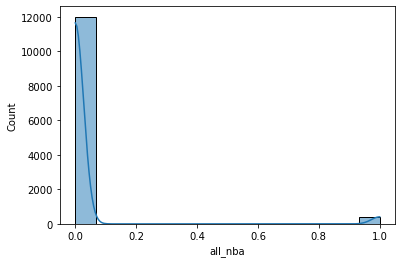

In [438]:
# Considering this high accuracy, I decided to checke the distribution of NBA Selections vs Non-Selections using a Histogram.
# As a result I obtained a plot that reflects that the data is highly unbalanced, almost all records are for non-selections.
sns.histplot(data=all_nba_df_filt, x='all_nba', kde=True)

2.4. What does this tells us about the data and the use of accuracy as an evaluation metric?

In [439]:
# This is telling us that the data is highly imbalanced, finding that almost 97% of players are non-selected. 
# The simplest metric for model evaluation is Accuracy. 
# Accuracy it is the ratio of the number of correct predictions to the total number of predictions made for a dataset. 
# It is useful when the target class is well balanced but is not a good choice with unbalanced classes.
# Accuracy gives us an overall picture of how much we can rely on our model’s prediction. 
# This metric is blind to the difference between classes and types of errors. 
# That’s why it is not good enough for imbalanced datasets, like in this case. 

In [440]:
nba_scaler = StandardScaler()

# I am dropping "team" as it is the only non-numerical feature on my dataset...

feats_to_scale = ['games', 'mp', 'fg_perc', '3p_perc', 
                                '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts']

# train dataset scaling 
allnba_x_train[feats_to_scale] = nba_scaler.fit_transform(allnba_x_train[feats_to_scale])

# test dataset scaling
allnba_x_test[feats_to_scale] = nba_scaler.transform(allnba_x_test[feats_to_scale])

<ipython-input-440-eeba66291c93>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  allnba_x_train[feats_to_scale] = nba_scaler.fit_transform(allnba_x_train[feats_to_scale])
C:\Users\abela\anaconda3\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
<ipython-input-440-eeba66291c93>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



2.6. Train a LogisticRegression with default parameters, use only the numerical features (omit the team information for now). This will be our baseline model. 

In [441]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(allnba_x_train[feats_to_scale], allnba_y_train)

LogisticRegression()

2.7. Evaluate our baseline model using this metrics: 

    - accuracy
    - precision
    - recall
    - f1

In [442]:
y_pred = log_reg.predict(allnba_x_test[feats_to_scale])

print("- Accuracy: {:.4%}".format(accuracy_score(allnba_y_test, y_pred)))
print("- Precision: {:.4%}".format(precision_score(allnba_y_test, y_pred)))
print("- Recall: {:.4%}".format(recall_score(allnba_y_test, y_pred)))
print("- F1: {:.4%}".format(f1_score(allnba_y_test, y_pred)))
print()

# I also used the Classification Report to double-check the scores...

targets = ['negative class', 'positive class']
print(classification_report(allnba_y_test, y_pred, target_names=targets))

# The classification report is about key metrics in a classification problem.
# With this report I can have precision, recall, f1-score and support for each class I'am trying to find.
# The recall means "how many of this class I can find over the whole number of element of this class"
# The precision is "how many are correctly classified among that class"
# The f1-score is the harmonic mean between precision & recall
# The support is the number of occurence of the given class in your dataset 
# so I have 3,600 negatives and just 126 positives which, as we analyzed before, means this is a really unbalanced dataset.

- Accuracy: 98.0945%
- Precision: 76.1905%
- Recall: 63.4921%
- F1: 69.2641%

                precision    recall  f1-score   support

negative class       0.99      0.99      0.99      3600
positive class       0.76      0.63      0.69       126

      accuracy                           0.98      3726
     macro avg       0.87      0.81      0.84      3726
  weighted avg       0.98      0.98      0.98      3726



From now on, you'll be evaluating you model primarily using the F1 Score metric, but we also want to avoid models that have very low recall. 

### Classification

#### Feature engineering

2.8. One hot encode the Team feature. Make sure to drop the original column.

In [443]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)

allnba_noteam = pd.DataFrame(ohe.fit_transform(all_nba_df_filt['team'].values.reshape(
                -1,1)),columns=ohe.get_feature_names(['team']))
allnba_noteam.reset_index(drop=True, inplace=True)

all_nba_df_filt.reset_index(drop=True, inplace=True)
all_nba_df_filt = all_nba_df_filt.join(allnba_noteam)
all_nba_df_filt = all_nba_df_filt.drop(['team'], axis=1)
all_nba_df_filt.tail()

,games,gamesstarted,mp,fg_perc,3p_perc,2p_perc,ft_perc,trb,ast,stl,...,team_POR,team_SAC,team_SAS,team_SEA,team_TOR,team_TOT,team_UTA,team_VAN,team_WAS,team_WSB
12414,40,17,18.8,0.387,0.306,0.453,0.775,2.7,0.8,0.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12415,54,12,15.3,0.346,0.336,0.355,0.760,2.4,0.9,0.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12416,32,2,6.7,0.731,0.000,0.731,0.724,1.9,0.2,0.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12417,38,11,16.0,0.529,0.000,0.536,0.653,4.2,0.8,0.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12418,43,0,9.5,0.500,0.000,0.504,0.765,2.9,0.6,0.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Modeling

2.9. Train a logistic regresion model, find the best hyperparameters for: tols, C and max_iter. Try at least 4 values of each parameter. Remember to select based on f1 score, but report also precision and recall. Save the best performing model to use in the next steps.

In [444]:
def search_best_hyperparameters_log(tols, c, max_iter):
    
    '''
    The purpose of this Function is to:
    1) Iterate the algorithm considering different configuration of hyperparameters.
    2) Use a For loop to start the iteration considering None value for the hyperparameters.
    3) Run the Logistic Regressor assigning the saved values of hyperparameters.
    4) Fit the trained data and build the predictor, saving in a local variable.
    5) Apply the F1, Precision & Recall Score.
    6) Use If and Else to bring the best hyperparameters for F1, Precision & Recall Score. 
        
    '''
    
    result = {"hyperparameters": {"tols": None, "c": None, "max_iter": None}, 
        "scores": {"f1": None, "precision": None, 
                   "recall": None     
                    }
                }
    
    for tls in tols:
        for ccc in c:
            for mit in max_iter:
                #print(f'{tls}-{ccc}-{mit}')
                log_reg = LogisticRegression(C=ccc, tol=tls, max_iter=mit)
                log_reg.fit(allnba_x_train[feats_to_scale], allnba_y_train)
                y_pred = log_reg.predict(allnba_x_test[feats_to_scale])
                f1 = f1_score(allnba_y_test, y_pred)
                score_precision = precision_score(allnba_y_test, y_pred)
                score_recall = recall_score(allnba_y_test, y_pred)               
                #print('F1 score: {:.2f}', {best_f1})
                if result["scores"]["f1"] == None:
                    result = {"hyperparameters": {"tols":tls,
                                                  "c":ccc,
                                                  "max_iter":mit
                                                    },
                              "scores": {"f1":f1,
                                         "precision":score_precision,
                                         "recall":score_recall
                                        }
                             }
                              
                elif result["scores"]["f1"] <= f1:
                    pass
                        
                else:
                      result = {"hyperparameters": {"tols":tls,
                                                  "c":ccc,
                                                  "max_iter":mit
                                                    },
                              "scores": {"f1":f1,
                                         "precision":score_precision,
                                         "recall":score_recall
                                        }
                             }

    return result

In [445]:
# I am trying these values for the selected hyperparameters...

tols = [0.0001, 0.001, 0.00001, 0.0002]
c = [1, 2, 3, 4]
max_iter = [100, 1000, 50, 75]

lowest_f1 = search_best_hyperparameters_log(tols, c, max_iter)

print(f'The lowest F1 Score found is: {lowest_f1}')

C:\Users\abela\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\abela\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

The lowest F1 Score found is: {'hyperparameters': {'tols': 0.0001, 'c': 1, 'max_iter': 100}, 'scores': {'f1': 0.6926406926406926, 'precision': 0.7619047619047619, 'recall': 0.6349206349206349}}


C:\Users\abela\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Evaluating on New Data

You're now going to evaluate the results on a test dataset that has not being used to train or do hyperparameter tuning, this is sometimes known as a Test set (in this cases the test set used for training is known as validation set, yeah, it's confusing, but you can read about it [here](https://machinelearningmastery.com/difference-test-validation-datasets/))

2.10. Load the dataset [all_nba_2018_dataset.csv](https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_dataset.csv) in one dataframe and [all_nba_2018_selections.csv](https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_selections.csv)) in another, then:

    - Scale the numerical features. Columns season_id, player_id, player_season, player, season and season_start will not be used for prediction, you can keep them but remember not to pass them to the classifier.
    
    - Create the one hot encoded features for team. This step will be complex, as you will have to consider that in the 2018 season there are 30 teams, but the previous dataset contains 40 teams, that is because a lot of teams changed names or cities over the years. You need to add those 10 different team names in this dataset (with all values in 0) to make the classifier work.

In [446]:
all_nba_2018_df = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_dataset.csv", index_col=0)
all_nba_2018_selections = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_selections.csv", index_col=0)
# As I am overwriting on the following code blocks, I decided to create one dataframe that is the original with no changes.
all_nba_2018_df_orig = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_dataset.csv", index_col=0)

In [447]:
# train dataset scaling
all_nba_2018_df[feats_to_scale] = nba_scaler.transform(all_nba_2018_df[feats_to_scale])

# Here I am creating an array for the All NBA 2018 Selections
all_nba_2018_selections_arr = all_nba_2018_selections['all_nba'].values.reshape(-1,1)

allnba_teams = pd.DataFrame(ohe.transform(all_nba_2018_df['team'].values.reshape(
                -1,1)),columns=ohe.get_feature_names(['team']))
allnba_teams.reset_index(drop=True, inplace=True)

all_nba_2018_df.reset_index(drop=True, inplace=True)
all_nba_2018_df = all_nba_2018_df.join(allnba_teams)
all_nba_2018_df = all_nba_2018_df.drop(['team'], axis=1)

# I am creating 2 lists of the teams, one for previous teams (until 2017) and other for current teams in 2018

prev_teams = ['team_ATL', 'team_BOS', 'team_BRK', 'team_CHA', 'team_CHH', 'team_CHI',
       'team_CHO', 'team_CLE', 'team_DAL', 'team_DEN', 'team_DET', 'team_GSW',
       'team_HOU', 'team_IND', 'team_LAC', 'team_LAL', 'team_MEM', 'team_MIA',
       'team_MIL', 'team_MIN', 'team_NJN', 'team_NOH', 'team_NOK', 'team_NOP',
       'team_NYK', 'team_OKC', 'team_ORL', 'team_PHI', 'team_PHO', 'team_POR',
       'team_SAC', 'team_SAS', 'team_SEA', 'team_TOR', 'team_TOT', 'team_UTA',
       'team_VAN', 'team_WAS', 'team_WSB']

curr_teams = ['team_ATL', 'team_BOS', 'team_BRK', 'team_CHI', 'team_CHO', 'team_CLE',
       'team_DAL', 'team_DEN', 'team_DET', 'team_GSW', 'team_HOU', 'team_IND',
       'team_LAC', 'team_LAL', 'team_MEM', 'team_MIA', 'team_MIL', 'team_MIN',
       'team_NOP', 'team_NYK', 'team_OKC', 'team_ORL', 'team_PHI', 'team_PHO',
       'team_POR', 'team_SAC', 'team_SAS', 'team_TOR', 'team_TOT', 'team_UTA',
       'team_WAS']

# After comparing the two lists I am getting the difference between of them here...
diff_teams = list(set(prev_teams).difference(curr_teams))

# Using a For loop I am creating new columns using the name of the columns that resulted from a difference above.
for team in diff_teams:
    all_nba_2018_df[team] = 0
    
# all_nba_2018_df.columns
all_nba_2018_df.head()

,season_id,player_id,player_season,player,season,season_start,games,gamesstarted,mp,fg_perc,...,team_POR,team_SAC,team_SAS,team_SEA,team_TOR,team_TOT,team_UTA,team_VAN,team_WAS,team_WSB
0,34,5,2,Alex Abrines,2018-19,2018,-0.886081,2,-0.139415,-0.825795,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0
1,49,8,7,Quincy Acy,2018-19,2018,-1.721597,0,-0.794793,-2.246416,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0
2,52,10,1,Jaylen Adams,2018-19,2018,-0.766722,1,-0.765447,-0.952072,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0
3,71,13,6,Steven Adams,2018-19,2018,1.063457,80,1.269159,1.678709,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0
4,79,15,2,Bam Adebayo,2018-19,2018,1.143030,28,0.281201,1.478769,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0


2.11. Predict and evaluate the model using precision, recall and f1 score. 

In [448]:
log_reg = LogisticRegression(C=2, tol=0.0001, max_iter=100)
log_reg.fit(allnba_x_train[feats_to_scale], allnba_y_train)
y_pred_log = log_reg.predict(all_nba_2018_df[feats_to_scale])
print()
print("- Precision: {:.4%}".format(precision_score(all_nba_2018_selections_arr, y_pred_log)))
print("- Recall: {:.4%}".format(recall_score(all_nba_2018_selections_arr, y_pred_log)))
print("- F1: {:.4%}".format(f1_score(all_nba_2018_selections_arr, y_pred_log)))


- Precision: 60.0000%
- Recall: 100.0000%
- F1: 75.0000%


2.12. Analyze the results, what do you think it is happening?

In [449]:
# Recall Score is indicating this model is very good at picking the correct items. Bad news it predicted more than the 15.
# Recall is a measure of how many of the positive cases the classifier correctly predicted, over all the positive cases.
# In this case almost all the 15 items out of 530 and the model were detected, so the recall is 93%.

# F1 Score here improves, as is combining both precision and recall scores. 
# Before we had 60% and now is 73%

#### Creating our custom Classifier

One thing to consider in this problem, is that the number of ALl NBA selections is fixed each year, a total of 15 players are always selected. But our current model does not limit the number of positive classified players. So, we will have to wrap our model in a custom classifier that only returns as positive the 15 players with the higher probabilities. 
Fortunately, our chosen model provides access to the underlying probabilities.

2.13. Using the trained model, predict probabilities for all rows in the dataset, and create a new column that has the probability that the player was selected as all nba. Round the probability to 3 decimals.

In [450]:
# I am using predict_proba to get the Probabilities of Selections "1" vs. Non Selections "0"
# To make it more readable I changed the names to "Predict" and "Probability"
mod_proba = log_reg.predict_proba(all_nba_2018_df[feats_to_scale])
proba_col = pd.DataFrame(mod_proba)
proba_col.rename(columns = {0:'Predict', 1:'Probability'}, inplace = True)
proba_col.head()

,Predict,Probability
0,0.999999,7.447522e-07
1,1.000000,1.421873e-08
2,0.999999,6.556281e-07
3,0.817243,1.827575e-01
4,0.990616,9.384488e-03


2.14. Sort the dataset by probabilities and show the 15 players with higher probability to have been selected

In [451]:
# I created an independent dataframe to get only the Probability on "1" that is Selected Players
proba_col = pd.DataFrame(proba_col)
proba_col = proba_col.drop(['Predict'], axis=1)
# Then I created a copy of the dataframe with Player Id and Player and combined with just created Probability dataframe. 
prob_data = all_nba_2018_df.copy()
prob_data.reset_index(inplace=True)
prob_data = prob_data.join(proba_col)
prob_data.drop(columns=["index"], inplace=True)
prob_data.index.name = None
prob_data = prob_data.filter(["player_id","player","Probability"], axis=1)
prob_data.sort_values("Probability", ascending=False).head(15)

,player_id,player,Probability
17,83,Giannis Antetokounmpo,0.998616
205,1024,James Harden,0.998426
125,587,Anthony Davis,0.997057
257,1240,LeBron James,0.993382
154,740,Joel Embiid,0.974346
505,2648,Russell Westbrook,0.965834
149,695,Kevin Durant,0.964709
491,2572,Nikola Vucevic,0.951765
300,1492,Kawhi Leonard,0.947174
182,884,Paul George,0.946199


2.15. Print:

    - Players actually selected from the all_nba_2018_selections dataset,
    - Players actually selected missing from OUR predictions+
    - Players in our predictions not selected 

In [353]:
# In order to get onlyl the 15 names that were selected I used a mask considering "1" on the original dataframe
# Then I filter that dataframe to have only the column of Player, and finally converting it to a list. 
mask_sel = (all_nba_2018_selections['all_nba'] == 1)
nba_sel_2018 = all_nba_2018_selections[mask_sel]
nba_sel_2018 = nba_sel_2018.filter(["player"], axis=1)
nba_sel_2018 = nba_sel_2018["player"].to_list()
nba_sel_2018

['Giannis Antetokounmpo',
 'Stephen Curry',
 'Kevin Durant',
 'Joel Embiid',
 'Paul George',
 'Rudy Gobert',
 'Blake Griffin',
 'James Harden',
 'Kyrie Irving',
 'LeBron James',
 'Nikola Jokic',
 'Kawhi Leonard',
 'Damian Lillard',
 'Kemba Walker',
 'Russell Westbrook']

In [452]:
# In order to get onlyl the 15 names that were selected I used a mask considering "1" on the original dataframe
# To get the highest values I sorted the data in descending order.
# Then I sliced the dataframe with the first 15 rows, and on the last step I converted it to a list. 
our_predict = prob_data
our_predict.sort_values(by='Probability', ascending=False, inplace=True)
our_predict = our_predict.reset_index(drop=True)
our_predict = our_predict[:15]
our_predict = our_predict.filter(["player","Probability"], axis=1)
our_predict = our_predict["player"].to_list()
our_predict

['Giannis Antetokounmpo',
 'James Harden',
 'Anthony Davis',
 'LeBron James',
 'Joel Embiid',
 'Russell Westbrook',
 'Kevin Durant',
 'Nikola Vucevic',
 'Kawhi Leonard',
 'Paul George',
 'Nikola Jokic',
 'Rudy Gobert',
 'Karl-Anthony Towns',
 'Damian Lillard',
 'Kemba Walker']

In [453]:
# Here I am comparing the real selection vs my prediction, to know the differences...
sel_vs_ours = list(set(nba_sel_2018).difference(our_predict))
print(sel_vs_ours)

['Blake Griffin', 'Stephen Curry', 'Kyrie Irving']


In [454]:
# Now here I get the differences the other way, comparing my prediction vs real selection.
ours_vs_sel = list(set(our_predict).difference(nba_sel_2018))
print(ours_vs_sel)

['Nikola Vucevic', 'Karl-Anthony Towns', 'Anthony Davis']


2.16. Create a class named AllNbaSingleSeasonClassifier that takes a scikit learn model in the constructor, then implements a predict method that returns predictions with only the 15 most probable selections.

In [455]:
class AllNbaSingleSeasonClassifier():
    
    def __init__(self, model):
        """
        
        In order to use this Function with any dataframe, I decided to create this Function from scratch.
        This means the Function does all the Feature Engineering, cleaning and processing of the data.
        Also transforms the data using the previous scaler and make a predictor using the Logistic Regressor.
        Finally as a result it brings an array with the prediction of the 15 best players.
        
        Class constructor
        
        Parameters
        ----------
        model: BaseEstimator
            a Scikit learn estimator
        """
        self._model = model
        
    def predict(self, X):
        """
        Predicts all nba selections. This classifier will limit the number
        of positive instances to 15
        
        Parameters
        ----------
        X: pd.DataFrame
            a dataframe with the players data
            
        Returns
        -------
        np.ndarray
            An array of the same length as y, with 15 true results based on the players with most probabilities of
            beign selected
        """
            
        feats_to_scale = ['games', 'mp', 'fg_perc', '3p_perc', 
                                '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts']    
        Xdif = X.copy()
        Xdif[feats_to_scale] = nba_scaler.transform(Xdif[feats_to_scale])
        allnba_teams = pd.DataFrame(ohe.transform(Xdif['team'].values.reshape(
            -1,1)),columns=ohe.get_feature_names(['team']))
        allnba_teams.reset_index(drop=True, inplace=True)
        Xdif.reset_index(drop=True, inplace=True)
        Xdif = Xdif.join(allnba_teams)
        Xdif = Xdif.drop(['team'], axis=1)
        
        prev_teams = ['team_ATL', 'team_BOS', 'team_BRK', 'team_CHA', 'team_CHH', 'team_CHI',
           'team_CHO', 'team_CLE', 'team_DAL', 'team_DEN', 'team_DET', 'team_GSW',
           'team_HOU', 'team_IND', 'team_LAC', 'team_LAL', 'team_MEM', 'team_MIA',
           'team_MIL', 'team_MIN', 'team_NJN', 'team_NOH', 'team_NOK', 'team_NOP',
           'team_NYK', 'team_OKC', 'team_ORL', 'team_PHI', 'team_PHO', 'team_POR',
           'team_SAC', 'team_SAS', 'team_SEA', 'team_TOR', 'team_TOT', 'team_UTA',
           'team_VAN', 'team_WAS', 'team_WSB']
        curr_teams = ['team_ATL', 'team_BOS', 'team_BRK', 'team_CHI', 'team_CHO', 'team_CLE',
           'team_DAL', 'team_DEN', 'team_DET', 'team_GSW', 'team_HOU', 'team_IND',
           'team_LAC', 'team_LAL', 'team_MEM', 'team_MIA', 'team_MIL', 'team_MIN',
           'team_NOP', 'team_NYK', 'team_OKC', 'team_ORL', 'team_PHI', 'team_PHO',
           'team_POR', 'team_SAC', 'team_SAS', 'team_TOR', 'team_TOT', 'team_UTA',
           'team_WAS']
        diff_teams = list(set(prev_teams).difference(curr_teams))
        
        mod_proba = log_reg.predict_proba(Xdif[feats_to_scale])
        
        proba_col = pd.DataFrame(mod_proba)
        proba_col.rename(columns = {0:'Predict', 1:'Probability'}, inplace = True)
        proba_col = pd.DataFrame(proba_col)
        proba_col = proba_col.drop(['Predict'], axis=1)
        
        Xdif.reset_index(inplace=True)
        Xdif = Xdif.join(proba_col)
        Xdif.drop(columns=["index"], inplace=True)
        Xdif.index.name = None
        Xdif = Xdif.filter(["player_id","player","Probability"], axis=1)
    
        our_predict = Xdif
        our_predict = our_predict.reset_index(drop=True)
        our_predict['selection'] = 0 
        our_predict.loc[our_predict.nlargest(15, 'Probability').index,'selection'] = 1
        our_predict = our_predict.filter(["selection"], axis=1)
        our_predict.values.reshape(-1,1)
        
        return our_predict

In [456]:
best_15 = AllNbaSingleSeasonClassifier(log_reg)
players_selected = best_15.predict(all_nba_2018_df_orig)
print(players_selected.shape)

(530, 1)


2.17. Use the new classifier to make predictions and evaluate the result with precision, recall and f1

#### Analyzing our results

In [457]:
# Here I am using both the Clasification Report and the Scores Functions from Scikit Learn

targets = ['non-selected', 'selected']
# print(classification_report(allnba_y_test, y_pred, target_names=targets))
print(classification_report(all_nba_2018_selections_arr, players_selected, target_names=targets))

print("- Precision: {:.4%}".format(precision_score(all_nba_2018_selections_arr, players_selected)))
print("- Recall: {:.4%}".format(recall_score(all_nba_2018_selections_arr, players_selected)))
print("- F1: {:.4%}".format(f1_score(all_nba_2018_selections_arr, players_selected)))

              precision    recall  f1-score   support

non-selected       0.99      0.99      0.99       515
    selected       0.80      0.80      0.80        15

    accuracy                           0.99       530
   macro avg       0.90      0.90      0.90       530
weighted avg       0.99      0.99      0.99       530

- Precision: 80.0000%
- Recall: 80.0000%
- F1: 80.0000%


2.18. What do you think it is the main problem with this dataset and the way we trained our model?

In [458]:
# The main problem is that is the data is highly unbalanced, with a small fraction of players being selected. 
# Another problem is that the small size of samples (530 players) can lead us to a very high prediction, using different scores. 

2.19. What do you think we could do to improve our model?

In [459]:
# We can intentionally train different datasets or validation sets where the data is balanced, 
# for example trying 60% Selections - 40% Non Selections or 50% - 50 forcing the model to learn this way. 

### Optional: Oversampling

2.19. Read about oversampling techniques, for example [SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html). Use this strategy to create synthetic data and retrain our model. Compare the results. 

## Optional: Developing a Linear Regressor class from scratch

Our last task will be to code a Linear Regression algorithm using Gradient Descent as its optimization algorithm in Python. The structure of the class is presented below, you should use numpy for numerical computation.

3.1. Write a LinearRegression class that implements fit and predict methods, and uses gradient descent as optimization algorithm

In [ ]:
    
class LinearRegressor:
    """Linear regression algorithm class. Implements gradient descent as optimization algorithm"""
    
    def __init__(self, epochs: int, learning_rate: float):
        """
        Class constructor
        
        Parameters
        ----------
        epochs: int
            number of epochs to run gradient descent
        learning_rate: float
            rate of update of the gradients
        """


    def _gradient_descent():
        """
        Gradient descent algorithm
        """


    def fit(self, X, y):
        """
        Fit the model according to the given training data.
        
        Parameters
        ----------
        X: np.ndarray
        y: np.ndarray
        """
             
    def predict(self, X):
        """
        Predict
        
        Parameters
        ----------
        X: np.ndarray
        
        Returns
        -------
        np.ndarray
            array with predictions
        """


3.2. Train a regression model with the data from the first section to calculate players salaries using points per game. Try with a few different values (3 or 4 for each should suffice) for epochs and learning rate parameters, calculate MAE for all results and save the best result along with the parameters values used.

3.3. Evaluate the model performance on the test set, and compare with the result you obtained using SGDRegressor from scikit-learn.